Ранее мы использовали наивную версию градиентного бустинга из scikit-learn, придуманную в 1999 году Фридманом. С тех пор было предложено много реализаций, которые оказываются лучше на практике. На сегодняшний день популярны три библиотеки, реализующие градиентный бустинг:

- <ins>XGBoost</ins>. После выхода быстро набрала популярность и оставалась стандартом до конца 2016 года. Об особенностях данной библиотеки рассказывалось на лекции.
- <ins>LightGBM</ins>. Отличительной чертой является быстрота построения композиции. Например, используется следующий трюк для ускорения обучения: при построении вершины дерева вместо перебора по всем значениям признака производится перебор значений гистограммы этого признака. Таким образом, вместо $O(\ell)$ требуется $O$(#bins). Кроме того, в отличие от других библиотек, которые строят дерево по уровням, LightGBM использует стратегию best-first, т.е. на каждом шаге строит вершину, дающую наибольшее уменьшение функционала. Таким образом каждое дерево является цепочкой с прикрепленными листьями, поэтому ограничение на num_leaves получается более осмысленным.
- <ins>CatBoost</ins>. Библиотека от компании Яндекс. Позволяет автоматически обрабатывать категориальные признаки. Кроме того, алгоритм является менее чувствительным к выбору конкретных гиперпараметров. За счёт этого уменьшается время, которое тратит человек на подбор оптимальных гиперпараметров.

#### Основные параметры
(lightgbm/catboost)

- objective – функционал, на который будет настраиваться композиция
- eta / learning_rate – темп (скорость) обучения
- num_iterations / n_estimators – число итераций бустинга

#### Параметры, отвечающие за сложность деревьев
- max_depth – максимальная глубина
- max_leaves / num_leaves – максимальное число вершин в дереве
- gamma / min_gain_to_split – порог на уменьшение функции ошибки при расщеплении в дереве
- min_data_in_leaf – минимальное число объектов в листе
- min_sum_hessian_in_leaf – минимальная сумма весов объектов в листе, минимальное число объектов, при котором делается расщепление
- lambda – коэффициент регуляризации (L2)
- subsample / bagging_fraction – какую часть объектов обучения использовать для построения одного дерева
- colsample_bytree / feature_fraction – какую часть признаков использовать для построения одного дерева

Подбор всех этих параметров — настоящее искусство. Но начать их настройку можно с самых главных параметров: learning_rate и n_estimators. Обычно один из них фиксируют, а оставшийся из этих двух параметров подбирают (например, фиксируют n_estimators=1000 и подбирают learning_rate). Следующим по важности является max_depth. В силу того, что мы заинтересованы в неглубоких деревьях, обычно его перебирают из диапазона [3; 7].

In [1]:
# Команда %matplotlib inline указывает, что график необходимо построить все в той же оболочке Jupyter, 
# но теперь он выводится как обычная картинка. Данный способ удобен тем, что позволяет проводить очень много 
# экспериментов в рамках одного окна (точнее web-страницы). 
# В этом статическом режиме, никакие изменения не отобразятся до тех пор пока не будет выполнена команда plt.show()

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)

In [3]:
X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

### Catboost

In [4]:
from catboost import CatBoostClassifier 

0.919452347083926


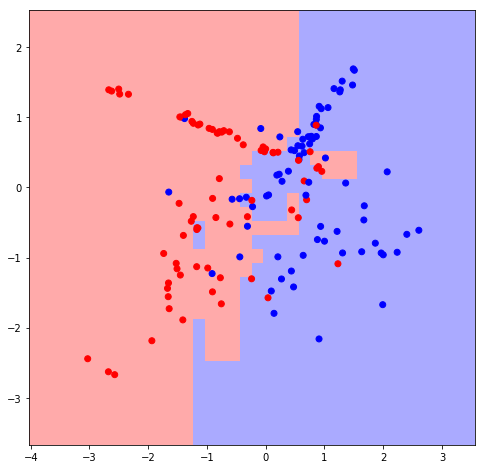

In [5]:
clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train, y_train)

plot_surface(X_test, y_test, clf)
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

In [6]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []

for n in n_trees:
    clf = CatBoostClassifier(iterations=n, logging_level='Silent')
    clf.fit(X_train, y_train)
    
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

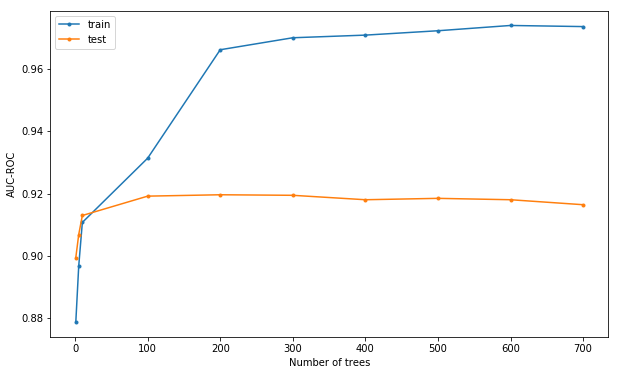

In [7]:
plt.figure(figsize=(10, 6))
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')

plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.legend()

plt.show()

### LightGBM

In [8]:
from lightgbm import LGBMClassifier

0.8629089615931721


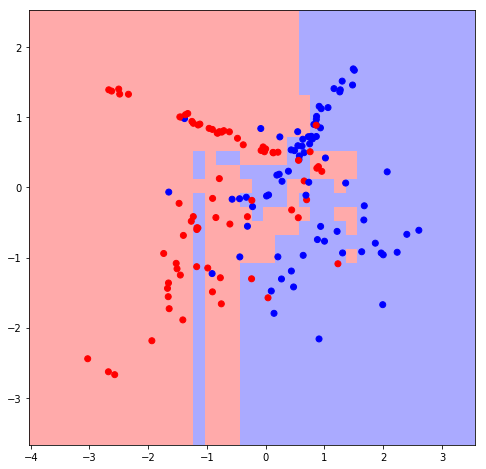

In [9]:
clf = LGBMClassifier(n_estimators=300)
clf.fit(X_train, y_train)

plot_surface(X_test, y_test, clf)
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

In [10]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals_train = []
quals_test = []

for n in n_trees:
    clf = LGBMClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

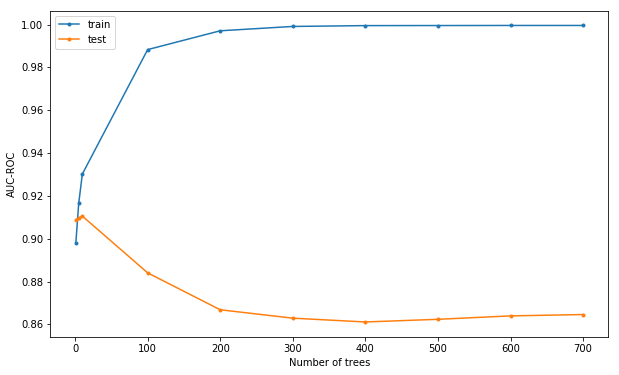

In [11]:
plt.figure(figsize=(10, 6))
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')

plt.plot(n_trees, quals_train, marker='.', label='train')
plt.plot(n_trees, quals_test, marker='.', label='test')
plt.legend()

plt.show()

Теперь попробуем взять фиксированное количество деревьев, но будем менять их глубину:

In [12]:
depth = list(range(1, 30, 3))
n_trees = 300
quals_train = []
quals_test = []

for d in depth:
    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d)
    lgb.fit(X_train, y_train)
    
    q_train = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

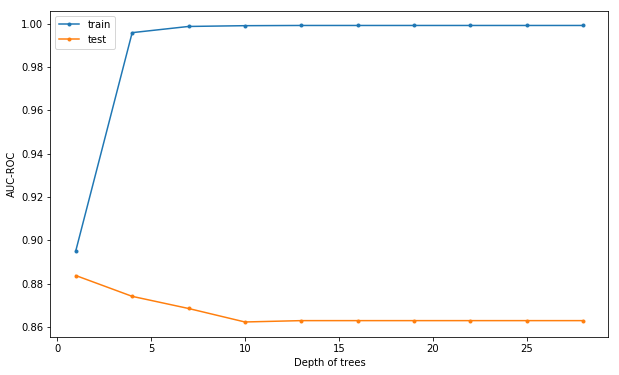

In [13]:
plt.figure(figsize=(10, 6))
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')

plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.legend()

plt.show()

Сравним с Catboost:

In [14]:
depth = list(range(1, 12, 2))
n_trees = 300
quals_train = []
quals_test = []

for d in depth:
    clf = CatBoostClassifier(n_estimators=n_trees, max_depth=d, logging_level="Silent")
    clf.fit(X_train, y_train)
    
    q_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
    q_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals_train.append(q_train)
    quals_test.append(q_test)

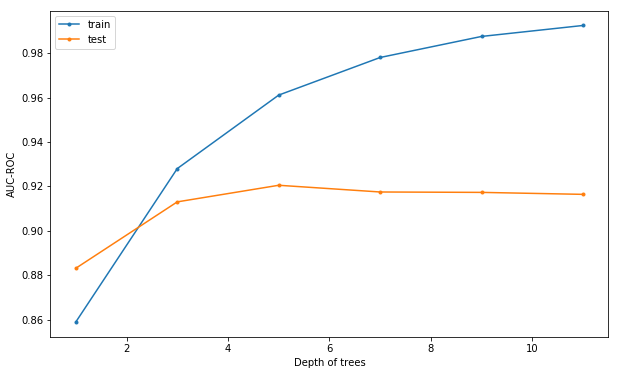

In [15]:
plt.figure(figsize=(10, 6))
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')

plt.plot(depth, quals_train, marker='.', label='train')
plt.plot(depth, quals_test, marker='.', label='test')
plt.legend()

plt.show()

Когда у нас получились отличные модели, нужно их сохранить:

In [16]:
lgb.booster_.save_model('lightgbm.txt')

clf.save_model('catboost.cbm', format='cbm')

Загрузим обратно, когда понадобится их применить:

In [17]:
lgb = LGBMClassifier(model_file='mode.txt')

clf = clf.load_model('catboost.cbm')

---

### Блендинг

блендинг представляет из себя "мета-алгоритм", предсказание которого строится как взвешенная сумма базовых алгоритмов. Рассмотрим простой пример блендинга бустинга и линейной регрессии:

In [18]:
from sklearn.datasets import load_boston
from catboost import CatBoostRegressor

In [19]:
data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [20]:
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    
    return np.sqrt(np.mean(error))

In [21]:
cbm = CatBoostRegressor(iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE', logging_level='Silent')
cbm.fit(X_train, y_train)

y_pred_cbm = cbm.predict(X_test)
y_train_pred_cbm = cbm.predict(X_train)

print("Train RMSE GB = %.4f" % rmse(y_train, y_train_pred_cbm))
print("Test RMSE GB = %.4f" % rmse(y_test, y_pred_cbm))

Train RMSE GB = 5.4431
Test RMSE GB = 6.5456


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_train_pred_lr = lr.predict(X_train_scaled)

print("Train RMSE LR = %.4f" % rmse(y_train, y_train_pred_lr))
print("Test RMSE LR = %.4f" % rmse(y_test, y_pred_lr))

Train RMSE LR = 4.4113
Test RMSE LR = 5.4154


Для простоты будем считать, что новый алгоритм $a(x)$ представим как 
$$ a(x)
=
\sum_{n = 1}^{N}
w_n b_n(x) $$

In [25]:
def select_weights(y_true, y_pred_1, y_pred_2):
    grid = np.linspace(0, 1, 1000)
    metric = []
    
    for w_0 in grid:
        w_1 = 1 - w_0
        y_a = w_0 * y_pred_1 + w_1 * y_pred_2
        metric.append([rmse(y_true, y_a), w_0, w_1])
        
    return metric

In [26]:
rmse_blending_train, w_0, w_1 = min(
                                    select_weights(y_train, y_train_pred_cbm, y_train_pred_lr), 
                                    key=lambda x: x[0]
                                )

In [27]:
rmse_blending_train

4.273424051954005

In [28]:
rmse(y_test, y_pred_cbm * w_0 +  y_pred_lr * w_1)

5.237314717927904

В итоге получаем качество на тестовой выборке лучше, чем у каждого алгоритма в отдельности.

---

### Важность признаков

Заказчику часто важно понимать, как работает алгоритм, почему он делает такие предсказания. Обсудим несколько мотиваций.
	
#### Доверие алгоритму
Например, а банках на основе решений, принятых алгоритмом, выполняются финансовые операции, и менеджер, ответственный за эти операции, будет готов использовать алгоритм, только если он понимает, что его решения обоснованы. По этой причине в банках очень часто используют простые линейные алгоритмы. Другой пример из области медицины: поскольку цена ошибки может быть очень велика, врачи готовы использовать только интерпретируемые алгоритмы.
	
#### Отсутствие дискриминации (fairness) 
Вновь пример с банком: алгоритм кредитного скоринга не должен учитывать расовую принадлежность (racial bias) заемщика или его пол (gender bias). Между тем, такие зависимости часто могут присутствовать в датасете (исторические данные), на котором обучался алгоритм.  Еще один пример: известно, что нейросетевые векторы слов содержат gender bias. Если эти вектора использовались при построении системы поиска по резюме для рекрутера, то например по запросу `technical skill` он будет видеть женские резюме в конце ранжированного списка.
	
#### Учет контекста
Данные, на которых обучается алгоритм, не отображают всю предметную область. Интерпретация алгоритма позволит оценить, насколько найденные зависимости связаны с реальной жизнью. Если предсказания интерпретируемы, это также говорит о высокой обобщающей способности алгоритма. 

Теперь обсудим несколько вариантов, как можно оценивать важность признаков.

##### Веса линейной модели

Самый простой способ, который уже был рассмотрен на семинаре про линейные модели: после построения модели каждому признаку будет соответствовать свой вес - если признаки масштабированы, то чем он больше по модулю, тем важнее признак, а знак будет говорить о положительном или отрицательном влиянии на величину целевой переменной.

##### FSTR

fstr говорит, что важность признака &mdash; это то, насколько в среднем меняется ответ модели при изменении значения данного признака (изменении значения разбиения).

Рассчитать его можно так:

$$feature\_importance_{F} = \sum_{tree, leaves_F} (v_1 - avr)^2\cdot c_1 +(v_2 - avr)^2\cdot c_2\\
\qquad avr = \frac{v_1 \cdot c_1 + v_2 \cdot c_2}{c_1 + c_2}.$$

Запись $leaves_F$ выше означает разбиение, зависящее от признака $F$.

Мы сравниваем поддеревья, отличающиеся значением сплита в узле на пути к ним: если условие сплита выполняется, объект попадает в левое поддерево, иначе &mdash; в правое. 

$c_1, c_2 - $  число объектов обучающего датасета, попавших в левое и правое поддерево соотвественно, либо суммарный вес этих объектов, если используются веса; $v1, v2 -$значение модели в левом и правом поддереве.


Далее значения $feature\_importance$ нормируются, и получаются величины, которые суммируются в 100.

In [29]:
for val, name in sorted(zip(
                            cbm.feature_importances_, 
                            data.feature_names)
                       )[::-1]:
    print(name, val)

LSTAT 44.57842395824728
RM 36.850858175652654
NOX 3.473133901367306
PTRATIO 3.3887271637105134
DIS 2.23667053074621
INDUS 1.9016830079470277
TAX 1.7781003730136429
CRIM 1.5774334311195715
AGE 1.4213295189456003
RAD 1.3943420902109485
B 0.6521915521536685
CHAS 0.6057385942178969
ZN 0.14136770266764145


In [30]:
sum(cbm.feature_importances_)

99.99999999999996

---

#### Out-of-bag

В случайном лесе за счет обучения на подвыборках можно использовать out-of-bag оценки - ошибка композиции $a(x) = \sum_{n=1}^N b_n(x)$, построенной с помощью бэггинга с базовыми алгоритмами $b_i(x)$, вычисляется по формуле:
     $$
     \text{OOB} = \sum_{i=1}^\ell L\biggl(y_i, \frac 1 {\sum_{n=1}^N [x_i \notin X_n]} \sum_{n=1}^N [x_i \notin X_n] b_n(x_i)\biggr)
      $$     
Можно показать, что по мере увеличения числа деревьев 
данная оценка стремится к leave-one-out-оценке,
но при этом существенно проще для вычисления.
     
Итоговый алгоритм подсчета важностей для случайного леса выглядит так:
* Вычислить OOB для случайного леса, обученного по исходной обучающей выборке
*  Для каждого признака $j$:

    * Перемешать значения признака по всем объектам обучающей выборки &mdash; мы хотим сделать признак неинформативным
    * Вычислить OOB$_j$ случайного леса, обученного по измененной обучающей выборке
    * Оценить важности: $R_j = \max(0, \text{OOB}-\text{OOB}_j)$

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
clf = RandomForestRegressor(n_estimators=100, oob_score=True)
clf.fit(X_train, y_train)

clf.oob_score_

0.837561435888132